<a href="https://colab.research.google.com/github/Somesh140/ANN/blob/main/gan_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May  9 12:51:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

170498071/170498071 [==============================] - 2s 0us/step


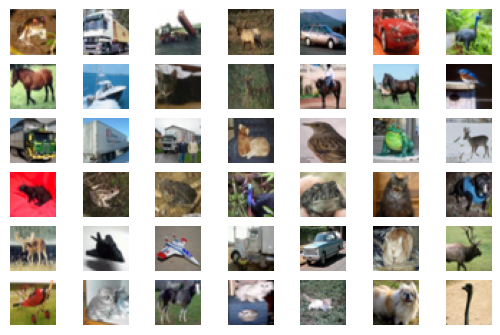

In [2]:
#Example of loading and plotting the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
#load the images into memory
(trainX, trainY), (testX, testY) = load_data()
#plot image from the training dataset
for i in range(42):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #trun of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(trainX[i])
pyplot.show()

In [4]:
trainX.shape

(50000, 32, 32, 3)

In [5]:
#Example of defining the discriminator model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np

In [6]:
#define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #normal
  model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape= in_shape))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
 
  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

  return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

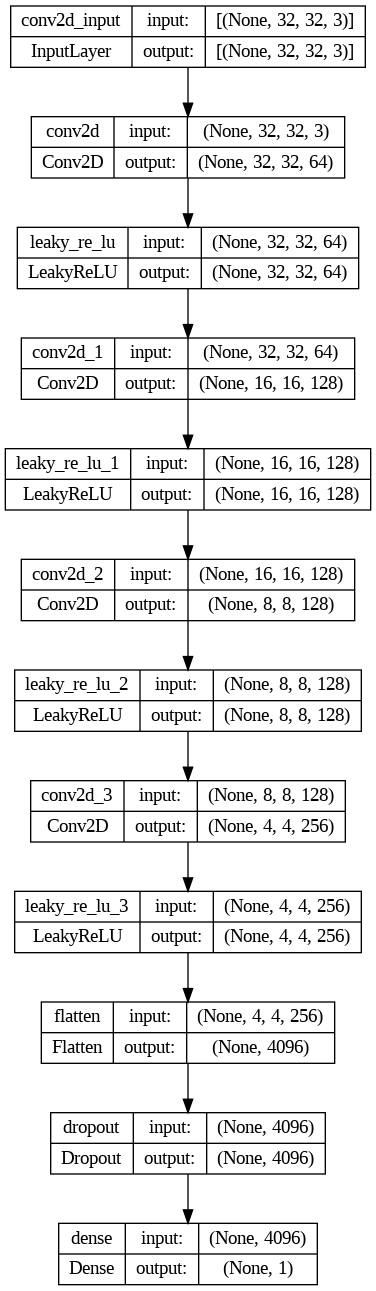

In [7]:
#define model
model = define_discriminator()
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
'''
Function to load the dataset & scale it
Load and prepare cifar10 training images
'''
def load_real_samples():
  #load cifar10 dataset
  (trainX,_), (_,_) = load_data()
  #convert from unsigned int to float
  X = trainX.astype('float32')
  #scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5

  return X 

In [9]:
#test
x = load_real_samples()
x.shape

(50000, 32, 32, 3)

In [12]:
trainX

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [13]:
x

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

In [14]:
# Select real samples with batches
def generate_real_samples(dataset,n_samples):
  #choose random instances
  index = np.random.randint(0, dataset.shape[0], n_samples)
  #retrive selected images
  X = dataset[index]
  #generate real class labels: (1)
  y = np.ones((n_samples,1))

  return X,y

In [16]:
#test
x,y = generate_real_samples(x,64)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [18]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
  #generate uniform random numbers in [0,1]
  X = np.random.rand(32 * 32 *3 * n_samples)
  #update to have the range [-1,1]
  X = -1 + X * 2
  # reshape into a batch of color images
  X = X.reshape((n_samples, 32,32,3))

  #generate fake class labels: (0)
  y = np.zeros((n_samples, 1))

  return X, y

In [19]:
#test
x,y = generate_fake_samples(64)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


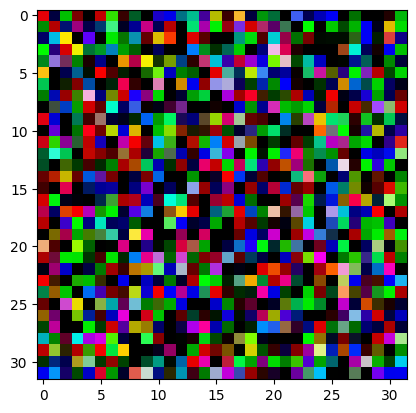

In [20]:
 # lets see our noise images how they look like
 pyplot.imshow(x[0])


In [21]:
#Train the discriminator model temporarily
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected real samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    #update discriminator on real samples
    _,real_acc = model.train_on_batch(X_real, y_real)
    #generates fake examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    #update discriminator on fake samples
    _,fake_acc = model.train_on_batch(X_fake, y_fake)
    #summarize performance
    print('>%d real = %.0f%% fake= %.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [22]:
# Example of training

#define the discriminator model
model = define_discriminator()
#load image data
dataset = load_real_samples()
#fit the model
train_discriminator(model, dataset)

>1 real = 47% fake= 0%
>2 real = 98% fake= 14%
>3 real = 89% fake= 44%
>4 real = 73% fake= 89%
>5 real = 83% fake= 100%
>6 real = 80% fake= 100%
>7 real = 83% fake= 100%
>8 real = 73% fake= 100%
>9 real = 77% fake= 100%
>10 real = 72% fake= 100%
>11 real = 91% fake= 100%
>12 real = 86% fake= 100%
>13 real = 84% fake= 100%
>14 real = 97% fake= 100%
>15 real = 98% fake= 100%
>16 real = 95% fake= 100%
>17 real = 97% fake= 100%
>18 real = 98% fake= 100%
>19 real = 98% fake= 100%
>20 real = 98% fake= 100%


In [24]:
# now work on Generator
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

In [25]:
#define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  #foundation for 4x4 image
  n_nodes = 256 * 4* 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))

  #upsample to 8x8 
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 16x16 
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 32x32 
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

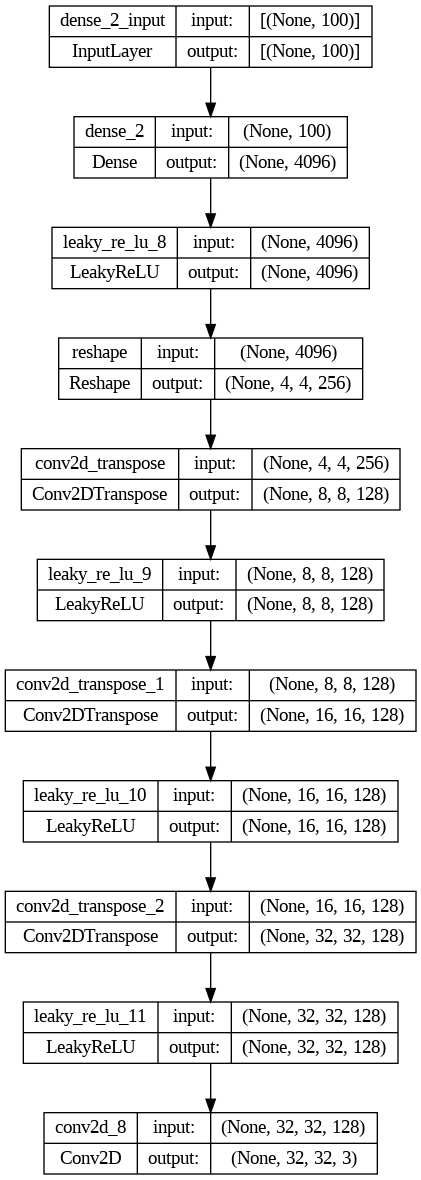

In [26]:
#define the size of the latent space
latent_dim = 100
#define the generator model
model = define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


In [27]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  #generate point in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  
  return x_input

In [28]:
#test
data = generate_latent_points(100,64)
print(data.shape)

(64, 100)


In [29]:
data

array([[ 1.06958237, -2.20646011, -0.55888751, ..., -0.1087873 ,
         0.82838915,  1.68995725],
       [ 0.18964973, -0.17216072, -1.16720566, ...,  0.09509673,
        -0.76770288,  0.62736545],
       [-0.15718561,  0.36970664, -0.4636706 , ...,  0.08113765,
        -0.47703675, -1.77305241],
       ...,
       [-0.32954119, -0.79008425, -1.59862328, ..., -0.48075555,
        -0.36947625, -0.84975851],
       [-0.06870935, -0.36552061,  1.92172649, ..., -0.01438413,
        -0.07549082,  0.8272297 ],
       [-0.60305705, -2.20507069, -0.05976744, ..., -0.194919  ,
        -0.50418536, -1.44220149]])

In [30]:
#use the generator to generate n fake examples with class labels
def generate_fake_images(g_model, latent_dim, n_sample):
  #generate point in the latent space
  x_input = generate_latent_points(latent_dim, n_sample)
  #predict output from generator
  X = g_model.predict(x_input)
  #create a fake class label: (0)
  y = np.zeros((n_sample,1))

  return X,y


2/2 [==============================] - 1s 129ms/step


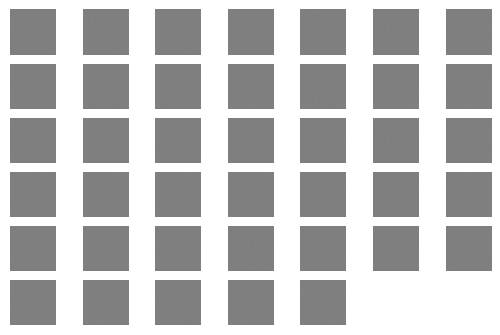

In [31]:
#size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
#generate samples
n_sample = 40 
X,_ = generate_fake_images(model, latent_dim, n_sample)
#scale the pixel value from [-1,1] to [0,1]
X = (X + 1) / 2.0
#plot the generated samples
for i in range(n_sample):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #turn of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(X[i])
pyplot.show()


In [32]:
#defining the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False
  #connect them
  model = Sequential()
  #add generator
  model.add(g_model)
  #add discriminator
  model.add(d_model)
  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam)

  return model


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


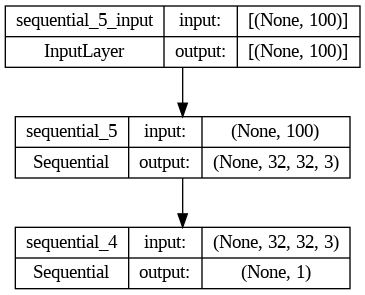

In [33]:
# size of the latent space
latent_dim = 100
#create discriminator
d_model = define_discriminator()
#create generator
g_model = define_generator(latent_dim)
#create the GAN
gan_model = define_gan(g_model, d_model)
#summarize the gan
gan_model.summary()
#plot the gan model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
#train the generator & dicriminator
def train(g_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected real samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      #update discriminator model weights
      d_loss1,_ = d_model.train_on_batch(X_real, y_real)
      #generate fake examples
      X_fake, y_fake = generate_fake_images(g_model,latent_dim, half_batch)
      #update discriminator model weights
      d_loss2,_ = d_model.train_on_batch(X_fake, y_fake)
      #prepare points in the latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for fake samples
      y_gan = np.ones((n_batch,1))
      #update the generator via the discriminator'r error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #summarize loss on this batches
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
            (i+i, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      
    #evaluate the model performance sometimes
    if (i+1) % 10 ==0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [35]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epochs, g_model, d_model, dataset, latent_dim, n_sample=150):
  #prepare real sample
  X_real, y_real = generate_real_samples(dataset, n_sample)
  #evaluate dicriminator on real examples
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  #prepare fake examples
  X_fake, y_fake = generate_fake_images(g_model,latent_dim, n_sample)
  #evaluate dicriminator on fake examples
  _,acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
  #save plot
  save_plot(X_fake, epochs)
  # save the generator model title file
  filename = 'generator_model_%03d.h5' % (epochs+1)
  g_model.save(filename)



In [36]:
# create and save a plot of generated images
def save_plot(examples, epochs,n=7):
  #scale the pixel value from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  #plot the generated samples
  for i in range(n*n):
    #define subplots
    pyplot.subplot(n,n,1+i)
    #turn of axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i])
  #save plot as file
  filename = 'generated_plot_%03d.png' % (epochs+1)
  pyplot.savefig(filename)
  pyplot.close()




In [38]:
train(g_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 13ms/step
>6, 232/390, d1=0.637, d2=0.543, g=1.033
2/2 [==============================] - 0s 5ms/step
>6, 233/390, d1=0.603, d2=0.649, g=1.014
2/2 [==============================] - 0s 16ms/step
>6, 234/390, d1=0.617, d2=0.591, g=1.038
2/2 [==============================] - 0s 8ms/step
>6, 235/390, d1=0.543, d2=0.528, g=1.077
2/2 [==============================] - 0s 13ms/step
>6, 236/390, d1=0.607, d2=0.532, g=1.063
2/2 [==============================] - 0s 12ms/step
>6, 237/390, d1=0.625, d2=0.672, g=0.997
2/2 [==============================] - 0s 7ms/step
>6, 238/390, d1=0.540, d2=0.636, g=1.019
2/2 [==============================] - 0s 12ms/step
>6, 239/390, d1=0.545, d2=0.615, g=1.018
2/2 [==============================] - 0s 8ms/step
>6, 240/390, d1=0.533, d2=0.568, g=1.086
2/2 [==============================] - 0s 5ms/step
>6, 241/390, d1=0.640, d2=0.719, g=1.141
2/2 [===================

2/2 [==============================] - 0s 5ms/step
>20, 1/390, d1=0.727, d2=0.664, g=0.883
2/2 [==============================] - 0s 8ms/step
>20, 2/390, d1=0.742, d2=0.578, g=0.928
2/2 [==============================] - 0s 9ms/step
>20, 3/390, d1=0.711, d2=0.581, g=0.969
2/2 [==============================] - 0s 7ms/step
>20, 4/390, d1=0.645, d2=0.579, g=0.965
2/2 [==============================] - 0s 9ms/step
>20, 5/390, d1=0.702, d2=0.570, g=0.931
2/2 [==============================] - 0s 8ms/step
>20, 6/390, d1=0.644, d2=0.622, g=0.886
2/2 [==============================] - 0s 4ms/step
>20, 7/390, d1=0.698, d2=0.675, g=0.837
2/2 [==============================] - 0s 6ms/step
>20, 8/390, d1=0.718, d2=0.681, g=0.855
2/2 [==============================] - 0s 8ms/step
>20, 9/390, d1=0.656, d2=0.681, g=0.821
2/2 [==============================] - 0s 6ms/step
>20, 10/390, d1=0.693, d2=0.606, g=0.841
2/2 [==============================] - 0s 9ms/step
>20, 11/390, d1=0.666, d2=0.688, g=0.8

KeyboardInterrupt: ignored

## Generation after training

4/4 [==============================] - 0s 53ms/step


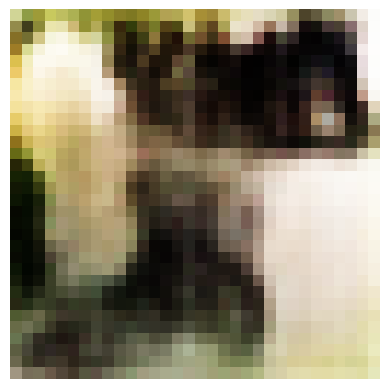

100

In [39]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


def create_plot(examples, n):
  for i in range(n * n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis("off")
    pyplot.imshow(examples[i, :, :])
  pyplot.show()


#load model
model = load_model("/content/generator_model_010.h5")
latent_point = generate_latent_points(100,100)
X = model.predict(latent_point)

X = (X+1)/2.0
create_plot(X,1)

X.shape[0]